# Investigating the Impacts of Urban Expansion
## Assessing Changes in the Biodiversity Intactness Index (BII) from 2017 to 2020 in Phoenix, AZ
### Author: Carmen Hoyt
#### Visit my [GitHub Repository](https://github.com/ceh58/biodiversity-phoenix) for more information.

### About
- Purpose

The purpose of this analysis is to identify the impacts of urban expansion by assessing where the Biodiversity Intactness Index (BII) decreased in Phoenix, Arizona from 2017 to 2020.

- Highlights

    - Filtering geo-dataframes (using `pandas` and `geopandas`)
    - Accessing an API using `pystac_client`
    - Extracting data from a desired `collection` and spatial extent (`bbox`)
    - Manipulating rasters (cleaning and clipping) with `rioxarray`

- Data

1. Biodiversity Intactness Index (BII) Time Series

In this analysis, I use the 2017 and 2020 rasters from the io-biodiversity collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). The collection was filtered using the following bounding box: [-112.826843, 32.974108, -111.184387, 33.863574].

2. Phoenix Subdivision Shapefile

The [2020 TIGER/Line® Shapefiles: County Subdivisions](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions) shapefile, as provided by the US Census Bureau, was downloaded for Arizona. This was filtered for Phoenix in the analysis.

- References

Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897 Accessed: 2024-12-02

2020 TIGER/Line Shapefiles (machinereadable data files) / prepared by the U.S. Census Bureau, 2020 https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions Accessed: 2024-12-02

### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # To plot the final figure
import geopandas as gpd # To work with shapefiles
import rioxarray as rioxr # To work with rasters

from pystac_client import Client # To access STAC catalogs

import planetary_computer # To sign items from the MPC STAC catalog

from IPython.display import Image # To nicely display images

## Import county subdivision shapefile

Download the [2020 TIGER/Line](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions) county subdivisions shapefile for Arizona and save in the data/ folder. Import the shapefile, and filter for Phoenix.

EPSG:4269


<Axes: >

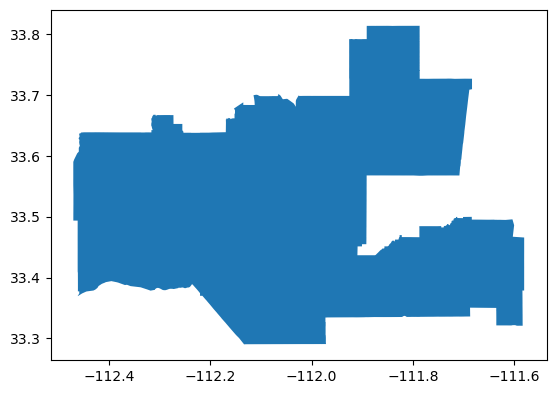

In [2]:
# Import shapefile from the data/ folder
counties = gpd.read_file(os.path.join("data/",
                  'tl_2020_04_cousub.shp'))

# Clean geo-dataframe names
counties.rename(columns=str.lower, inplace=True)

# Filter for Phoenix
phoenix = counties.loc[(counties['name'] == "Phoenix")]

# Examine Phoenix 
print(phoenix.crs)
phoenix.plot()

### Access the Biodiversity Intactness Index (BII)
We use the `Client` function from the `pystac_client` package to access the Microsoft Planetary Catalog STAC API:

In [3]:
# Access the Microsoft Planetary Catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Explore catalog metadata
print('Title: ', catalog.title)
print('Description: ', catalog.description)

Title:  Microsoft Planetary Computer STAC API
Description:  Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


We can access its collections by using the `get_collections()` method:

In [5]:
# Get collections and print their names
collections = list(catalog.get_collections()) # Turn the generator into a list

print('Number of collections ', len(collections))

print('Collection IDs (first 10): ')
for i in range(10):
    print('-', collections[i].id)

Number of collections  124
Collection IDs (first 10): 
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


There are 124 collections in this catalog. We are interested in the `io-biodiversity` collection. To `search()` for BII data from this catalog for Phoenix, AZ, we will need to specify `collections` and a bounding box (`bbox`).

In [6]:
# Specify bounding box for Phoenix, AZ
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search io-biodiversity catalog using the bbox
search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_of_interest)

# Print all of the items returned in the search
items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


Our search returned 4 items: BII data for each year from 2017 to 2020. We want to select the 2017 (item[0]) and the 2020 (item[3]) data.

In [7]:
# Get first item (2020 data) in the catalog search
item_2020 = items[0]
item_2020

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [8]:
# Print item ID and properties
print('ID: ', item_2020.id)
item_2020.properties

# Explore item assets
for key in item_2020.assets.keys():
    print(key, "--", item_2020.assets[key].title)

ID:  bii_2020_34.74464974521749_-115.38597824385106_cog
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


## Load data

The raster data in our current `item` is in the `data` asset.
Again, we access this data via its URL.
This time we open it using `rioxr.open_rasterio()` and save it as `bii_2020`, since it is the 2020 BII data.

In [9]:
# Access and save 2020 raster data
bii_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
# Preliminary exploration
print('Sizes of dimensions:', dict(bii_2020.sizes))
print('attrs:', bii_2020.attrs)
print(bii_2020.dims, bii_2020.coords)

Sizes of dimensions: {'band': 1, 'y': 7992, 'x': 7992}
attrs: {'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


The dimension 'band' of size 1 is not useful. We can drop it using the `squeeze()` and `.drop_vars()`functions.

In [11]:
# Drop the 'band' dimension
bii_2020 = bii_2020.squeeze().drop_vars('band')

In [12]:
# Confirm 'band' was dropped
print(bii_2020.dims, bii_2020.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


Now we will do the same for the 2017 data.

In [13]:
# Get third item (2017) in the catalog search
item_2017 = items[3]
item_2017

<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>

In [14]:
# Access and save 2017 raster data
bii_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
bii_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [15]:
# Drop the 'band' dimension
bii_2017 = bii_2017.squeeze().drop_vars('band')

# Confirm 'band' was dropped
print(bii_2017.dims, bii_2017.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In order to plot the Phoenix shapefile and the BII data on the same figure, we will need to make sure that the Coordinate Reference Systems (CRSs) match. We can use either the 2020 or the 2017 data, since they are from the same collection. I chose to use the 2020 data.

In [16]:
# Match CRSs and verify update
phoenix_match = phoenix.to_crs(bii_2020.rio.crs)
assert phoenix_match.crs == bii_2020.rio.crs

The rasters are very large; we will need to clip them to the extent of the Phoenix subdivision (using the shapefile with the matched CRS). 

In [17]:
# Clip the 2020 raster to detailed geometry
bii_2020_clip = (bii_2020.rio.clip_box(*phoenix_match.total_bounds)
                .rio.clip(phoenix_match.geometry))

# Clip the 2017 raster to detailed geometry
bii_2017_clip = (bii_2017.rio.clip_box(*phoenix_match.total_bounds)
                .rio.clip(phoenix_match.geometry))

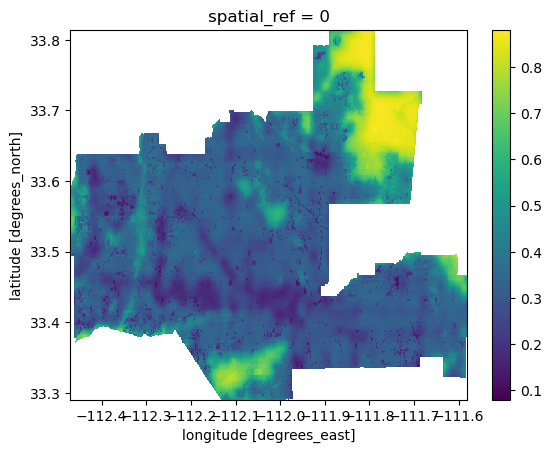

In [18]:
bii_2020_clip.plot()

## Calculate *percent* area with BII > 0.75

To calculate the percentage of area of the Phoenix subdivision with a BII of *at least* 0.75, we will need two values:

- Value 1: Number of pixels with BII values >= 0.75
- Value 2: Total number of pixels (in the Phoenix subdivision)

We will start with 2020 data. To find Value 1:

In [19]:
# Filter for BII >= 0.75
bii_75_2020 = bii_2020_clip >= 0.75

This produces a Boolean array, assigning True (BII >= 0.75) or False (BII < 0.75) values to each entry.

Use the `numpy` function `np.unique()` to return the unique values in the array. We must set the parameter `return_counts` to True in order to return the count (in this case, number of pixels) associated with each unique value (True or False).

In [20]:
# Count pixels for True/False for 2020
values, counts = np.unique(bii_75_2020, return_counts = True)

Create a dataframe from the values and counts we saved in the previous step. 

In [21]:
# Create a dataframe
d = {'values': values, 'counts': counts}
pix_counts_2020 = pd.DataFrame(data=d)
pix_counts_2020.head()

,values,counts
0,False,555184
1,True,21986


Value 1 is the number returned as `count` for True, located at [1,1]. Save it for later.

In [22]:
# Save the number of pixels that have BII > 0.75
value_1_2020 = pix_counts_2020.iloc[1,1]
print(f"There are {value_1_2020} pixels with BII > 0.75.")

There are 21986 pixels with BII > 0.75.


To find Value 2, we need to find the total number of pixels inside the Phoenix subdivision. First, we need to create another Boolean array for the whole study area. For this, we can use the full raster (clipped to the Phoenix subdivision).

In [23]:
# Find Boolean values for Phoenix subdivision
phoenix_2020_pixels = bii_2020_clip > 0

We will use the same method to return the counts for each True (inside the Phoenix subdivision boundary) or False (outside the subdivision boundary) value.

In [24]:
# Count pixels for True/False for the study area
values, counts = np.unique(phoenix_2020_pixels, return_counts = True)

# Create a dataframe
d = {'values': values, 'counts': counts}
phoenix_2020_total_pixels = pd.DataFrame(data=d)
phoenix_2020_total_pixels.head()

,values,counts
0,False,238471
1,True,338699


Since we are interested in the number of pixels inside the boundary, we want to select the counts value for True, located at [1,1]. Save it for later.

In [25]:
# Calculate total pixels inside subdivision
value_2_2020 = phoenix_2020_total_pixels.iloc[1,1]
print(f"The total number of pixels within the Phoenix border is {value_2_2020}.")

The total number of pixels within the Phoenix border is 338699.


To obtain the percent area, we need to divide Value 1 by Value 2 and multiply by 100.

In [26]:
# Find area percentage
percentage_area_2020 = (value_1_2020/value_2_2020) *100
print(f"The percentage of area of the Phoenix subdivision with BII > 0.75 in 2020 is {round(percentage_area_2020, 2)}%.")

The percentage of area of the Phoenix subdivision with BII > 0.75 in 2020 is 6.49%.


Now let's do the same for 2017 data. 

In [27]:
# Filter for BII >= 0.75
bii_75_2017 = bii_2017_clip >= 0.75

# Count pixels for True/False of BII > 0.75 for 2017
values, counts = np.unique(bii_75_2017, return_counts = True)

# Create a dataframe
d = {'values': values, 'counts': counts}
pix_counts_2017 = pd.DataFrame(data=d)

# Save the number of pixels that have BII > 0.75
value_1_2017 = pix_counts_2017.iloc[1,1]
print(f"There are {value_1_2017} pixels with BII > 0.75.")

# Find Boolean values for Phoenix subdivision 
phoenix_2017_pixels = bii_2017_clip > 0

# Count pixels for True/False for the study area
values, counts = np.unique(phoenix_2017_pixels, return_counts = True)

# Create a dataframe
d = {'values': values, 'counts': counts}
phoenix_2017_total_pixels = pd.DataFrame(data=d)
phoenix_2017_total_pixels.head()

# Calculate total pixels inside subdivision
value_2_2017 = phoenix_2017_total_pixels.iloc[1,1]
print(f"The total number of pixels within the Phoenix border is {value_2_2017}.")

# Find area percentage
percentage_area_2017 = (value_1_2017/value_2_2017) *100
print(f"The percentage of area of the Phoenix subdivision with BII > 0.75 in 2017 is {round(percentage_area_2017, 2)}%.")

There are 24133 pixels with BII > 0.75.
The total number of pixels within the Phoenix border is 338699.
The percentage of area of the Phoenix subdivision with BII > 0.75 in 2017 is 7.13%.


Using the boolean array, I masked the original clipped raster to focus on areas with BII > 0.75. I then subtracted the 2020 BII from the 2017 BII to identify areas where BII changed.

In [ ]:
change = bii_75_2017*bii_2017_clip - bii_75_2020*bii_2020_clip
#change = bii_2017_clip - bii_2020_clip
#change = change > 0
#change = bii_75_2017 - bii_75_2020
change.plot()

In [ ]:
aspect = bii_2020_clip.rio.width/bii_2020_clip.rio.height

fig, ax = plt.subplots(figsize = (10, 4*aspect))

# Plot the 2017 raster
bii_2020_clip.plot(ax=ax, 
                cmap = "Greens",
                cbar_kwargs={
        "orientation": "horizontal",
        "label": "BII for 2020"})

# Plot the difference raster
#change.plot(ax = ax,
           # cbar_kwargs={"orientation": "horizontal"})

# Plot the phoenix border
phoenix_match.boundary.plot(ax = ax,
                         color = "black")

ax.set_title("Biodiversity Intactness Index (BII) \nPhoenix Subdivision")
ax.axis("off")

plt.show()